# 의료영상 분류

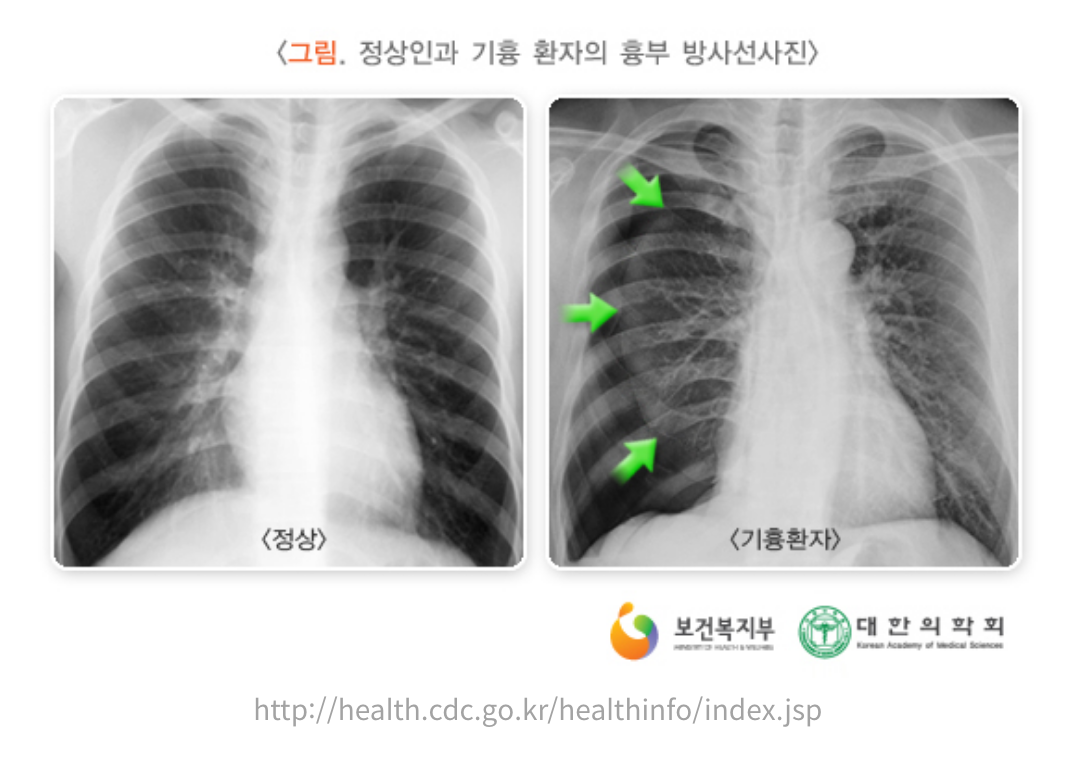

## X-RAY
* X-RAY는 전자는 물체에 충돌시킬 때 발생하는 투과력이 강한 복사선(전자기파)을 말한다. X-RAY는 방사선의 일종으로 지방, 근육, 천 종이 같이 밀도가 낮은 것은 수월하게 통과하지만, 밀도가 높은 뼈, 금속 같은 물질은 잘 통과하지 못한다.


## CT
* CT는 Computed Tomography의 줄임말로, 환자를 중심으로 X-RAY를 빠르게 회전하여 3D 이미지를 만들어내는 영상이다. 
환자의 3차원 이미지를 형성하여 기본 구조는 물론 가능한 종양 또는 이상을 쉽게 식별하고 위치를 파악할 수 있다.

## MRI
* MRI는 자기 공명 영상의 줄임말로 신체의 해부학적 과정과 생리적 과정을 보기 위해 사용하능 의료 영상 기술이다. MRI스캐너는 강한 자기장을 사용하여 신체 기관의 이미지를 생성한다. MRI는 CT, X-RAY와 다르게 방사선을 사용하지 않아서 방사선의 위험성에서는 보다 안전하다.

## More X-RAY
X-RAY 이미지를 이해하려면, X-RAY 영상을 촬영하기 위해 사용되는 자세 분류 체계를 이해하는 것이 중요하다.
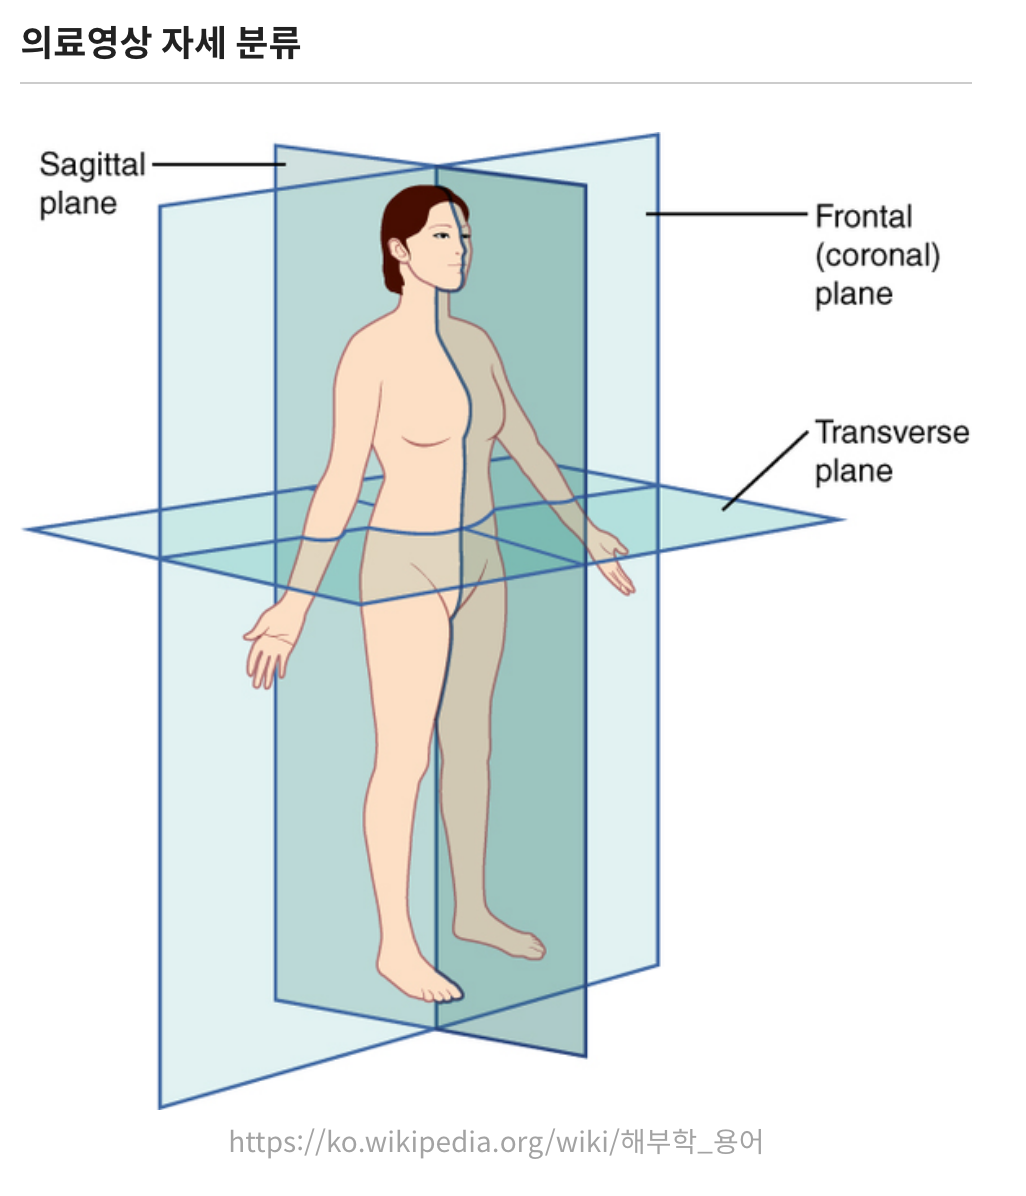
세 방향의 단면으로 나눈다면,
* Sagittal plane: 시상면. 사람을 왼쪽과 오른쪽을 나누는 면.
* Coronal plane: 관상면. 인체를 앞뒤로 나누는 면.
* Transverse plane: 횡단면(수평면). 인체를 상하로 나누는 면.

#### 하나의 예시로
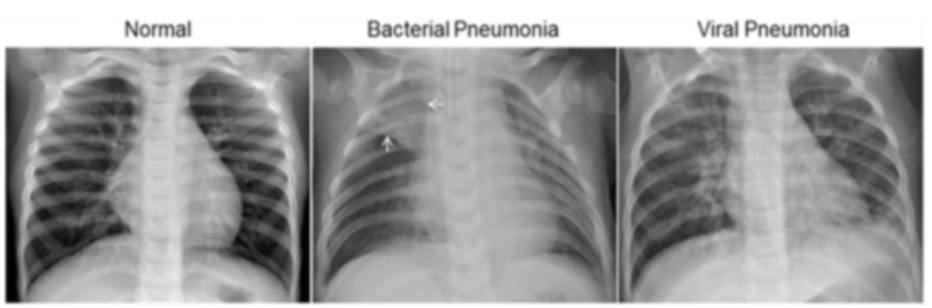
위 이미지는 흉부 부분이며 폐와 갈비뼈가 보이는 것을 육안으로 확인 가능하다.
(위 이미지는 관상면 이미지)


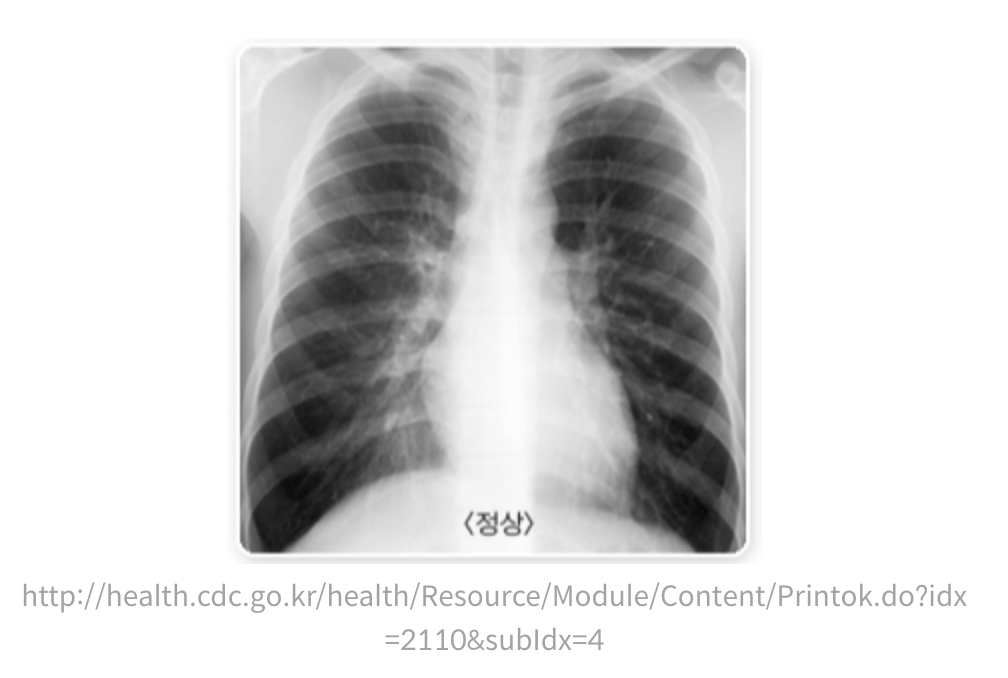
* 갈비뼈: 하얀색
* 폐: 검은색
* 어깨 쪽의 지방 및 근육: 연한 회색

# 폐렴을 진단해보자
딥러닝 모델을 만들어 폐렴을 찾아낼 것이다.

* 데이터 set 
캐글의 Chest X-Ray Images  
해당 이미지는 중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5 세 소아 환자의 흉부 X선 영상

### 폐렴 구별법
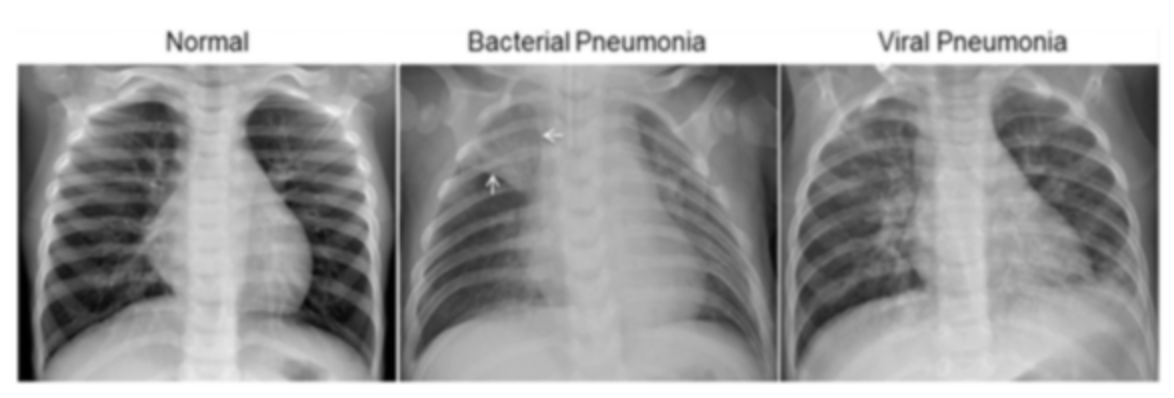
정상적인 흉부 X-RAY(왼쪽)은 이미지에서 비정상적인 음영 영역이 없는 깨끗한 폐를 보여준다.  
세균성 폐렴(가운데)은 일반적으로 오른쪽 상부 엽(흰색 화살표)에 있는 나타나는 반면,  바이러스성 폐렴(오른쪽)은 양쪽 폐에서보다 확산된 "interstitial(조직 사이에 있는)" 패턴으로 나타난다.

이러한 패턴을 잘 읽어내는 딥러닝 알고리즘을 만들어보자.

In [1]:
# Set up
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 28
EPOCHS = 50

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
#get Data

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))


5216
624
16


validation 데이터가 너무 적어 밸런스 조정을 위해 train과 val의 데이터를 모은  다음  8:2로 분할함.

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데
# 다행히도 파일 경로에 힌트가 있어요
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1589_virus_2763.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1346_bacteria_3430.jpeg


In [6]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")


Normal images count in training set: 1088
Pneumonia images count in training set: 3097


정상보다 폐렴 이미지 수가 3배 더 많이 있다. 우리가 사용할 CNN모델의 경우 데이터가 클래스별 balance가 좋을수록 trainig을 잘한다.

In [7]:
#tf.data 인스턴스를 만들어 배치처리 작업을 효율적으로 할 수 있도록 한다.

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


* 현재 이미지의 라벨이 따로 없기때문에 라벨데이터를 만드는 함수를 정의한다.

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)


* 이미지 사이즈를 통일 시키고 메모리 효율을 위해 이미지 사이즈를 줄인다.

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
#이미지 확인하기
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [13]:
# test data set

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용 
할 수 있게 해준다.  
- prepare_for_traing(): 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환 시켜줌.
- shuffle(): 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택한다.
- repeat():  epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 한다.
- batch(): BATCH_SIZE에서 정한 만큼 배치로 주어진다.

In [14]:

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)


### 데이터 시각화

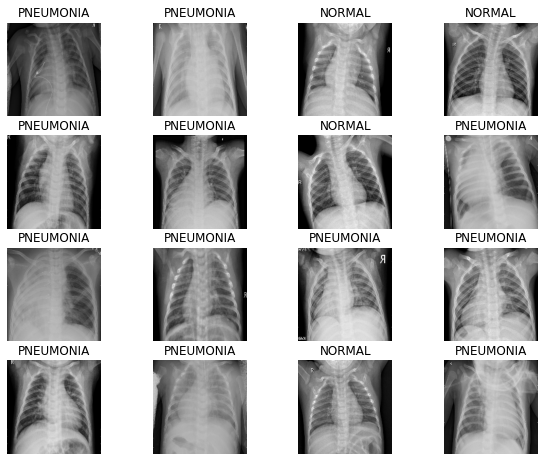

In [15]:
# train에서 batch 중 첫 번째 배치를 추출하고, Image와 label 데이터셋으로 나눔.
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

#### Result:
여러 형태의 폐 사진에 라벨이 잘 붙었다.

#### CNN 모델링

* 우선 Convolution block을 만든다.

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

* Dense Block을 만든다.

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

기존 CNN모델과 약간 다른 모델인데, 위에서는 Batch Normalization과 Dropout이라는 두 가지  regularization 기법이 동시에 사용됐다.  
(일반적으로는 쓰이지 않는 방식이다. Ref)https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf)
아래 모델을 살펴보자.

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
   
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 데이터 imbalance 처리

'Normal'과 폐렴에서 'Pneumonia'중에 'Pneumonia'데이터가 많았다.  
이를 해결하기 위해 weight balancing이라는 테크닉을 쓴다.  
Ref) https://3months.tistory.com/414

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.92
Weight for PNEUMONIA: 0.68


weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅.  
이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정

### 모델 트레이닝

In [20]:
with tf.device('/GPU:0'): #GPU를 사용하기 위해
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',#라벨이 두개여서 바이너리 로스 선택
        metrics=METRICS
    )

In [21]:
# Define some callbacks to improve training.
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss',mode='min',patience=10, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=5)


- Model Fit

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[es],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 54s 135ms/step - loss: 0.5834 - accuracy: 0.7116 - precision: 0.9056 - recall: 0.6772 - val_loss: 0.6530 - val_accuracy: 0.7490 - val_precision: 0.7490 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 34s 131ms/step - loss: 0.3163 - accuracy: 0.8769 - precision: 0.9651 - recall: 0.8637 - val_loss: 0.8840 - val_accuracy: 0.7519 - val_precision: 0.7519 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 34s 131ms/step - loss: 0.2616 - accuracy: 0.8918 - precision: 0.9720 - recall: 0.8805 - val_loss: 0.2228 - val_accuracy: 0.9288 - val_precision: 0.9836 - val_recall: 0.9206
Epoch 4/25
261/261 [==============================] - 34s 130ms/step - loss: 0.2068 - accuracy: 0.9203 - precision: 0.9741 - recall: 0.9178 - val_loss: 0.1814 - val_accuracy: 0.9135 - val_precision: 0.9929 - val_recall: 0.8912
Epoch 5/25
261/261 [==============================] - 34s 131ms/step - loss: 0.2009 - accura

- 결과 확인

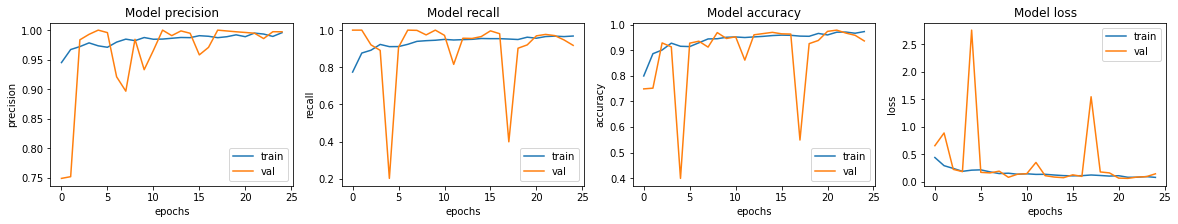

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

- 모델 평가하기

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 74ms/step - loss: 0.3905 - accuracy: 0.8814 - precision: 0.8744 - recall: 0.9462
Loss: 0.39053255319595337,
Accuracy: 0.8814102411270142,
Precision: 0.8744075894355774,
Recall: 0.9461538195610046



더 좋은 성능 개선을 위한 방법은?
데이터가 적기때문에 Data augumentation 방법을 많이 쓴다.(이미지 회전, 가우시안 노이즈 추가 등)  
GAN을 이용한 방법도 있다고 한다.


평가문항

1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.
모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.  


2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.
regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.  


3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.
Accuracy 기준 85%에 도달하였다.

## 회고:
validation 데이터가 너무 적어 밸런스 조정을 위해 train과 val의 데이터를 모아 다시 재분할하는 과정이 흥미로웠다. 이 밸런스가 CNN모델의 학습능력에 있어 중요한 요소가 된다.
의료 데이터 분석 모델에 있어서는 accuracy도 중요하지만 recall의 값도 못지 않게 중요하다.  
Data argumentation을 알아보던 중 ImageDataGenerator 클래스를 알게 되었고, 이것을  
사용해서 데이터를 증량하고 싶다는 생각이 들어서 추가학습을 해 볼 생각이다.

# 추가 작업
#### ImageDataGenerator 사용해보기

In [53]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'



print(ROOT_PATH)

/aiffel/aiffel


In [54]:
#get Data

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))


5216
624
16


데이터 수가 적어 Data를 늘려보겠다.

## Data argumentation
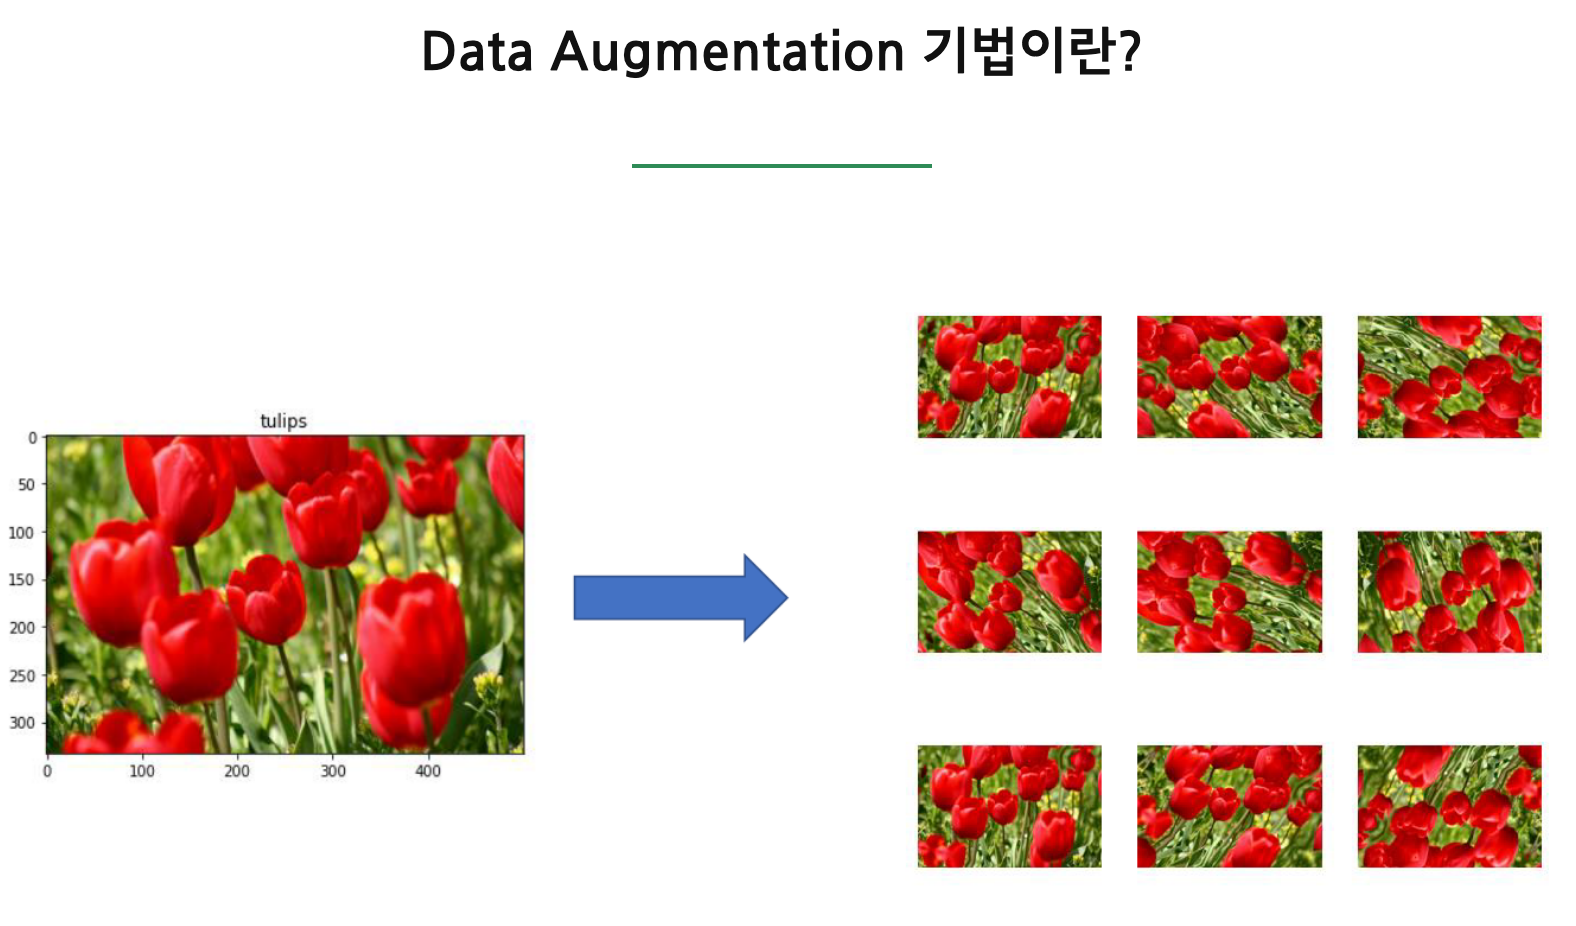


In [55]:
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import argparse
import numpy as np



## Image Generator 적용해보기

In [56]:
from keras_preprocessing.image import ImageDataGenerator

ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test'

In [57]:
train_datagen = ImageDataGenerator(rotation_range = 45,
                                    width_shift_range = 0.25,
                                    height_shift_range = 0.25,
                                    zoom_range = 0.25,
                                    horizontal_flip=True
                                   )

In [58]:
test_datagen = ImageDataGenerator(rotation_range = 45,
                                    width_shift_range = 0.25,
                                    height_shift_range = 0.25,
                                    zoom_range = 0.25,
                                    horizontal_flip=True
                                   )

training_set = train_datagen.flow_from_directory(TRAIN_PATH,
                                                 target_size = (180,180),
                                                 batch_size = 64,
                                                 class_mode = 'binary')

Found 5216 images belonging to 2 classes.


In [59]:
val_datagen = ImageDataGenerator(rotation_range = 45,
                                    width_shift_range = 0.25,
                                    height_shift_range = 0.25,
                                    zoom_range = 0.25,
                                    horizontal_flip=True
                                    )
val_set = val_datagen.flow_from_directory(VAL_PATH,
                                                 target_size = (180,180),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 16 images belonging to 2 classes.


In [60]:
test_set = test_datagen.flow_from_directory(TEST_PATH,
                                            target_size = (180,180),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 624 images belonging to 2 classes.


## 모델 트레이닝2

In [61]:
# def augment(image,label):
#     image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
#     return image,label

# def prepare_for_training(ds, shuffle_buffer_size=1000):
#     # augment 적용 부분이 배치처리 함수에 추가되었습니다.
#     ds = ds.map(
#             augment,       # augment 함수 적용
#             num_parallel_calls=2
#         )
#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE)
#     ds = ds.prefetch(buffer_size=AUTOTUNE)

#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)


In [62]:
with tf.device('/GPU:0'): #GPU를 사용하기 위해
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',#라벨이 두개여서 바이너리 로스 선택
        metrics=METRICS
    )

In [63]:

es = EarlyStopping(monitor='val_loss',mode='min',patience=10, verbose=1)


In [65]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

### 결과
accuracy는 낮아졌지만, recall값이 매우 높아졌다.

## 회고2
keras_preprocessing.image의 ImageDataGenerator를 써서 이미지 증강을 하고 싶었다. 
이 메소드 안에 여러 변수를 넣고 커스텀하면서 기존 이미지를 좀 더 늘리는 식으로 하여 부족한 이미지 데이터의 양을 조금이나마 늘려 학습할 수 있었다.